<a href="https://colab.research.google.com/github/etgins/Mice_ASD_Detection/blob/main/final_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------------------------------------------
Written by Itamar Ginsberg & Alon Schreuer, November 2021


Imports and setup
----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import os
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import GridSearchCV

Data and pre-process
----

In [ ]:
# load data from xls/csv file
dataset = pd.read_csv("/content/drive/MyDrive/Project_A/Project_A_files/processed_data_for_final_classification_REDUCTION_BY_RECORDING.csv", header=None)
# dataset.info()

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

In [ ]:
# pre-process data
  # normalize - different magnitudes between features (!!!)

# print(X.iloc[0,0:5])
scaler = StandardScaler().fit(X)
# print(scaler.mean_)
# print(scaler.var_)
# print(scaler.scale_)
X_scaled = scaler.transform(X)
# X_scaled = pd.DataFrame(data=X_scaled) #TODO - need this?
# print(X_scaled[0,0:5])

In [ ]:
# train-val-test split data (80-10-10)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1)
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=(1/9))


# transform data to DMatrix - a format XGboost can handle well (TODO - relevant?)
# D_train = xgb.DMatrix(X_train, label=y_train)
# D_validation = xgb.DMatrix(X_validation, label=y_validation)
# D_test = xgb.DMatrix(X_test, label=y_test)


XGBoost:
------------
✅ 1. https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101

2. https://towardsdatascience.com/ensemble-learning-and-model-interpretability-a-case-study-95141d75a96c

✅3. https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
- good conceptual explanation of the evolution of decision trees and XGBoost

✅4. https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7
- Gradient boosting for decision trees:
  - ensemble method, iteratively creating new trees, each focused on correcting the previous tree's mistakes (each model is trained on the so-far model's errors).


5. https://towardsdatascience.com/a-journey-through-xgboost-milestone-2-f3410109be5a
6. Official XGBoost website: https://xgboost.readthedocs.io/en/latest/parameter.html

✅7. Tune Learning Rate for Gradient Boosting - https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/

FULL EXAMPLE FROM SOURCE 1
---

Train Accuracy:  0.9090909090909091
Test Accuracy:  0.81
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.53      0.64        32
         1.0       0.81      0.94      0.87        68

    accuracy                           0.81       100
   macro avg       0.81      0.74      0.76       100
weighted avg       0.81      0.81      0.80       100

accuracy vec:  234     True
426     True
54     False
257     True
279     True
       ...  
203     True
318     True
160    False
55     False
487     True
Name: 41, Length: 100, dtype: bool true labels:  234    1.0
426    1.0
54     0.0
257    1.0
279    0.0
      ... 
203    1.0
318    1.0
160    1.0
55     0.0
487    1.0
Name: 41, Length: 100, dtype: float64


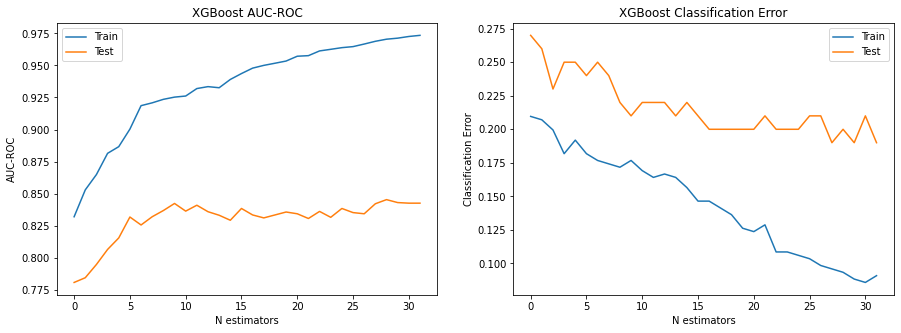


Confusion Matrix:
[[17 15]
 [ 4 64]]


<Figure size 720x360 with 0 Axes>

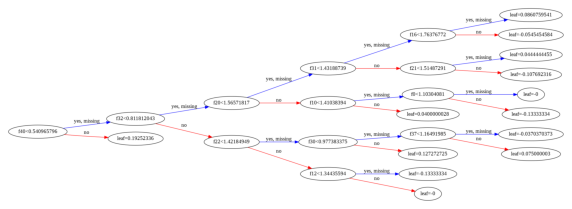

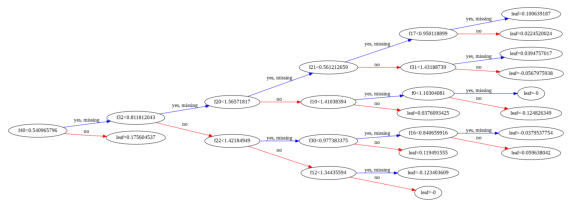

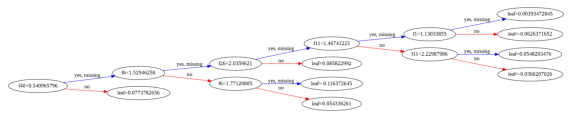

In [ ]:
# FULL EXAMPLE FROM SOURCE 1 AS IS
#---------------------------------------------------------
seed = 100
# the only step necessary to be done outside of pipeline
# convert the target column to categorical
# col = pd.Categorical(y)
# y = pd.Series(col.codes)
# validate the preprocessing pipeline by passing data through it

# clean_X = preprocessing_pipeline.fit_transform(X)
# clean_X_df = pd.DataFrame(clean_X, columns=X.columns)
# split the clean_X into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.20, random_state=seed, shuffle=True, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed, shuffle=True)

import time
from xgboost import XGBClassifier
# create a default XGBoost classifier
model = XGBClassifier(n_estimators=32, random_state=seed,learning_rate=0.1, max_depth=5, objective='binary:logistic', booster='gbtree', feval='rmsle')
# 81: n_estimators=32, random_state=seed,learning_rate=0.1, max_depth=5


# define the eval set and metric
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
# fit the model
# %time 
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)



from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# final model assessment
pred_train = model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))

pred_test = model.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, pred_test))

print('Classification Report:')
print(classification_report(y_test,pred_test,zero_division=0))



# CHECK ACCURACY BY HAND TO BE SURE:
# print('calculate accuracy by hand - not from example:', '\n')
accuracy_vec = pred_test == y_test
print('accuracy vec: ', accuracy_vec, 'true labels: ', y_test)
# num = accuracy_vec.sum()
# print('num = ', num)
# den = len(accuracy_vec)
# print('den = ', den)
# print('by-hand accuracy is:', np.round(accuracy_vec.sum()/len(accuracy_vec)), 3)






# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()


from sklearn.metrics import confusion_matrix
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
#---------------------------------------------------------


plt.rcParams['figure.figsize'] = [15, 10]
xgb.plot_tree(model,num_trees=0, rankdir='LR')
xgb.plot_tree(model,num_trees=1, rankdir='LR')
xgb.plot_tree(model,num_trees=31, rankdir='LR')

# SAVE MODEL TO FILE
import pickle
file_name = "XGBmodel_051221.pkl"
# save
pickle.dump(model, open(file_name, "wb"))
!cp "XGBmodel_051221.pkl" /content/drive/MyDrive/Project_A/Project_A_files

[0.02244117 0.03779877 0.02639452 0.         0.03165377 0.
 0.0441658  0.02610057 0.0358285  0.         0.02993767 0.02118382
 0.02632405 0.         0.         0.         0.0375407  0.02697619
 0.         0.         0.03879978 0.04540868 0.03708301 0.
 0.         0.         0.02637543 0.04418632 0.05039079 0.
 0.03241672 0.03370915 0.04472166 0.         0.         0.
 0.03887511 0.0354213  0.03846123 0.         0.16780537]


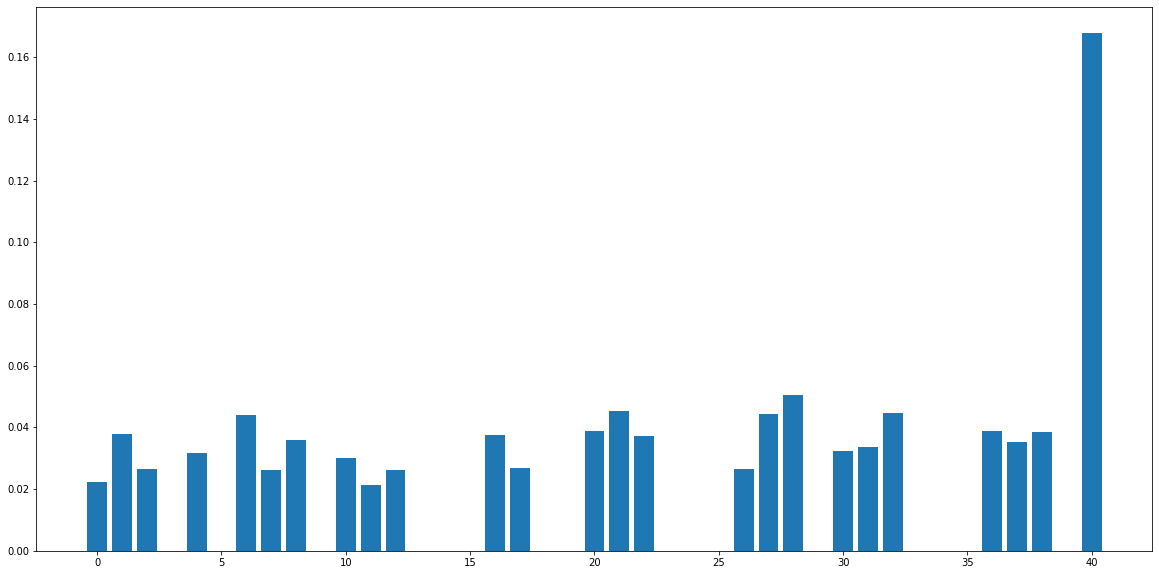

In [ ]:
# FEATURE IMPORTANCE - MANUALLY
print(model.feature_importances_)

import matplotlib.pyplot as plt
# # plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()


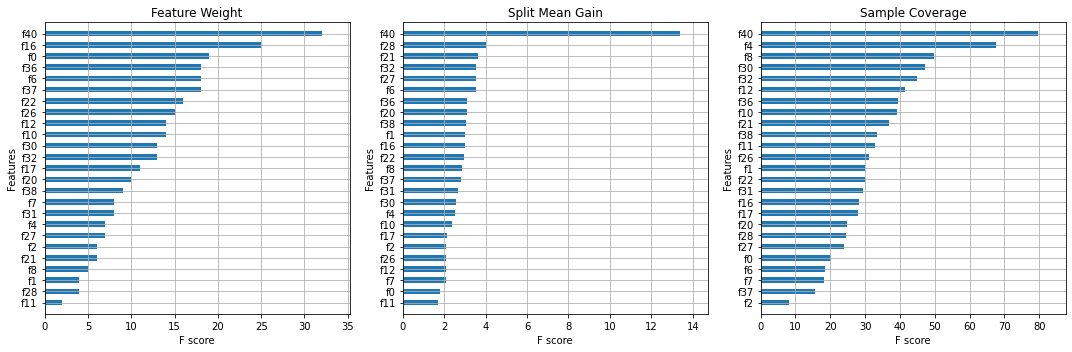

In [ ]:
# PLOT FEATURE IMPORTANCE:

# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(15,5))
# plot importances with feature weight

xgb.plot_importance(
    booster=model, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0]
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=model,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    model,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

***by using GridSearch (archived below):***

Best model: {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}

ARCHIVE - USING GRIDSEARCH TO FIND BEST HYPER-PARAMETERS
---

In [ ]:
# #---------------------------------------------------------

# # create a default XGBoost classifier
# from sklearn.metrics import make_scorer
# seed = 1000
# model = XGBClassifier(
#     random_state=seed, 
#     eval_metric=["error", "auc"]
# )
# # Create the grid search parameter grid and scoring funcitons
# param_grid = {
#     "learning_rate": [0.5,0.1, 0.01, 0.001],
#     "colsample_bytree": [0.6, 0.8, 1.0],
#     "subsample": [0.6, 0.8, 1.0],
#     "max_depth": [2, 3, 4, 5],
#     "n_estimators": [25, 50, 100, 200, 300, 400, 500],
#     "reg_lambda": [1, 1.5, 2],
#     "gamma": [0, 0.1, 0.3],
# }
# scoring = {
#     'AUC': 'roc_auc',
#      'Accuracy': make_scorer(accuracy_score)
# }
# # create the Kfold object
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import RandomizedSearchCV
# num_folds = 5
# kfold = StratifiedKFold(n_splits=num_folds)#, random_state=seed)
# # create the grid search object
# n_iter=50
# grid = RandomizedSearchCV(
#     estimator=model, 
#     param_distributions=param_grid,
#     cv=kfold,
#     scoring=scoring,
#     n_jobs=-1,
#     n_iter=n_iter,
#     refit="AUC",
# )
# # fit grid search
# %time best_model = grid.fit(X_train,y_train)
# from sklearn.metrics import confusion_matrix

# print(f'Best score: {best_model.best_score_}')
# print(f'Best model: {best_model.best_params_}')

# pred_test = best_model.predict(X_test)
# pred_train = best_model.predict(X_train)
# print('Train Accuracy: ', accuracy_score(y_train, pred_train))
# print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
# print('\nConfusion Matrix:')
# print(confusion_matrix(y_test,pred_test))
# print('\nClassification Report:')
# print(classification_report(y_test,pred_test))

# # store the winning model in a new variable
# xgc = best_model.best_estimator_
# # saving the feature names to the model
# xgc.get_booster().feature_names = X.columns.to_list()
# # PLOT FEATURE IMPORTANCE:
# # # Create the feature importances plot
# # fig, ax = plt.subplots(1, 3, figsize=(15,5))
# # # plot importances with feature weight
# # xgb.plot_importance(
# #     booster=xgc, 
# #     importance_type='weight',
# #     title='Feature Weight',
# #     show_values=False,
# #     height=0.5,
# #     ax=ax[0],
# # )
# # # plot importances with split mean gain
# # xgb.plot_importance(
# #     booster=xgc,
# #     importance_type='gain',
# #     title='Split Mean Gain',
# #     show_values=False,
# #     height=0.5,
# #     ax=ax[1]
# # )
# # # plot importances with sample coverage
# # xgb.plot_importance(
# #     xgc,
# #     importance_type='cover',
# #     title='Sample Coverage',
# #     show_values=False,
# #     height=0.5,
# #     ax=ax[2]
# # )
# # plt.tight_layout()
# # plt.show()


# # TAKEN FROM EXAMPLE WITHOUT GRID SEARCH:
# # retrieve performance metrics
# results = xgc.evals_result()
# epochs = len(results['validation_0']['error'])
# x_axis = range(0, epochs)
# fig, ax = plt.subplots(1, 2, figsize=(15,5))
# # plot auc
# ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
# ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
# ax[0].legend()
# ax[0].set_title('XGBoost AUC-ROC')
# ax[0].set_ylabel('AUC-ROC')
# ax[0].set_xlabel('N estimators')
# # plot classification error
# ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
# ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
# ax[1].legend()
# ax[1].set_title('XGBoost Classification Error')
# ax[1].set_ylabel('Classification Error')
# ax[1].set_xlabel('N estimators')
# plt.show()
# plt.tight_layout()


# # plot a decision tree from the booster
# xgb.plot_tree(booster=xgc, num_trees=0, ax=ax, rankdir='LR')
# plt.tight_layout()
# plt.show()

CPU times: user 1.14 s, sys: 76.2 ms, total: 1.22 s
Wall time: 32.7 s
Best score: 0.7558168350168349
Best model: {'subsample': 0.8, 'reg_lambda': 1.5, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Train Accuracy:  0.8409090909090909
Test Accuraccy:  0.77

Confusion Matrix:
[[12 20]
 [ 3 65]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.38      0.51        32
         1.0       0.76      0.96      0.85        68

    accuracy                           0.77       100
   macro avg       0.78      0.67      0.68       100
weighted avg       0.78      0.77      0.74       100



AttributeError: ignored

ARCHIVE - TUNE LEARNING RATE (from source 7)
---

In [ ]:
# # XGBoost on Otto dataset, Tune learning_rate and n_estimators
# from pandas import read_csv
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
# import matplotlib
# matplotlib.use('Agg')
# from matplotlib import pyplot
# import numpy
# # load data
# # data = read_csv('train.csv')
# # dataset = data.values
# # # split data into X and y
# # X = dataset[:,0:94]
# # y = dataset[:,94]
# # encode string class values as integers
# label_encoded_y = LabelEncoder().fit_transform(y)
# # grid search
# model = XGBClassifier()
# n_estimators = [100, 200, 300, 400, 500]
# learning_rate = [0.0001, 0.001, 0.01, 0.1]
# param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(X, label_encoded_y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# # plot results
# scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# pyplot.legend()
# pyplot.xlabel('n_estimators')
# pyplot.ylabel('Log Loss')
# pyplot.savefig('n_estimators_vs_learning_rate.png')